In [1]:
import os 
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'
os.environ['NETKET_EXPERIMENTAL_FFT_AUTOCORRELATION'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
import netket as nk

import sys
# sys.path.append('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/4x4_RBM_Refined_Learning/WithoutLog_Files')
# sys.path.append('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/AFM_VMC')
sys.path.append('/scratch/samiz/Model')
import jax.numpy as jnp
import matplotlib.pyplot as plt

import flax.linen as nn
from typing import Any
from netket.jax import logsumexp_cplx

from Afm_Model_functions import *
from vmc_2spins_sampler import *
from Spin_Observables import *
import pickle
import ViT_2d_Vers6 as vit
from data_extracter import *
import os
from jax import vmap

nk.config.netket_random_state_fallback_warning = False

### Comparison of RBM and ViT ansatz with differnet patching 

first import vit data

In [5]:
L = 6

# hi2d = nk.hilbert.Spin(s=0.5, N=L**2, constraint=Mtot_Parity_Constraint(parity=0))
TriGraph = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0, 1, 2, 3, 4, 5,
                   12, 13, 14, 15, 16, 17,
                   24, 25, 26, 27 ,28, 29]
}

Ha36, hi2d = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True,
                        parity=0., sublattice = None, make_rotation=False, exchange_XY=False)

Ha36_SS = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=False,
                        parity=0., sublattice = pHa['sublattice'], make_rotation=True, exchange_XY=True)


print('the Hilbert space is: ', hi2d)
XX = Exchange_OP(hi2d, TriGraph).to_jax_operator()

sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d, graph=TriGraph, n_chains=32, sweep_size=3*hi2d.size)

rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])
sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d, rules5050, n_chains=32, sweep_size=3*hi2d.size)


def Sz_tot(graph, hilbert):
    """
    input:
    graph: (netket.graph) the graph of the system
    hilbert: (netket.hilbert) the hilbert space of the system

    return:
    the total Sz operator
    """
    Sz = 0.0
    Ntot = graph.n_nodes
    for i in range(Ntot):
        Sz += sigmaz(hilbert, i)
    return Sz/Ntot

Mtot = Sz_tot(nk.graph.Triangular(extent=[L,L], pbc=True), hi2d)


the Hilbert space is:  Spin(s=1/2, N=36, ordering=inverted, <vmc_2spins_sampler.Mtot_Parity_Constraint object at 0x7f667c121b10>)


In [6]:
pVit = {
    'd': 24,
    'h': 6,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 2,
    'Cy': 2,
    'patch_arr': HashableArray(jnp.array([[0,1,6,7], [2,3,8,9], [4,5,10,11],
                                           [12,13,18,19], [14,15,20,21], [16,17,22,23],
                                             [24,25,30,31], [26,27,32,33], [28,29,34,35]])),
    }

# m_Vit12 = vit.Vit_2d_full_symm(patch_arr=HashableArray(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
#                                 Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
#                                 recover_full_transl_symm=False, recover_spin_flip_symm=True)


idy = jnp.arange(0,L**2)
Tx = jnp.roll(idy.reshape(-1,L), shift=1, axis=0).reshape(-1)
transls = HashableArray(jnp.array([idy, Tx]))



pVit['transls'] = transls  


m_Vit22 = vit.Vit_2d_full_symm(patch_arr=(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations=pVit['transls'], recover_spin_flip_symm=True)



m_Vit22_nl2 = vit.Vit_2d_full_symm(patch_arr=(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=2,
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations=pVit['transls'], recover_spin_flip_symm=True)


m_Vit22_nl3 = vit.Vit_2d_full_symm(patch_arr=(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=3,
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations=pVit['transls'], recover_spin_flip_symm=True)


ID = jnp.arange(0, L**2)
R = vit.make_first_reflection(ID, L)
Glide_Rot = vit.rot180_trans1(ID, L)
GRR = vit.trans_product(Glide_Rot, R)
arr = jnp.array([ID, R, Glide_Rot, GRR])

m_vit22_ref = vit.reflection_wrapper(model=m_Vit22, reflections=HashableArray(arr))



In [7]:
#--------------
vit_22 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit22, n_samples=2**12, n_discard_per_chain=16)
vit_22_ref = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_vit22_ref, n_samples=2**12, n_discard_per_chain=16)

# with open('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/nl_1/patching_xy22/Log_Files/log_vit_sampler_HaEx_5050_transflip_refined.pickle', 'rb') as handle:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/6x6_ViT_Refined_Learning/nl_1/patching_xy22/Log_Files/log_vit_sampler_HaEx_5050_transflip_refined.pickle', 'rb') as handle:

    ps = pickle.load(handle)
vit_22.variables = ps
vit22_pytree = vit_22_ref.variables
vit22_pytree['params']['model'] = ps['params']
vit_22_ref.variables = vit22_pytree
#--------------


vit_22_sign = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit22, n_samples=2**12, n_discard_per_chain=16)


# with open('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/nl_1/patching_xy22_SignStructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as handle:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/6x6_ViT_Refined_Learning/nl_1/patching_xy22_SignStructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as handle:

    ps = pickle.load(handle)

vit_22_sign.variables = ps


#--------------
vit_22_nl2 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit22_nl2, n_samples=2**12, n_discard_per_chain=16)

# with open('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/nl_2/patching_xy22/Log_Files/log_vit_sampler_HaEx_5050_transflip_refined.pickle', 'rb') as handle:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/6x6_ViT_Refined_Learning/nl_2/patching_xy22/Log_Files/log_vit_sampler_HaEx_5050_transflip_refined.pickle', 'rb') as handle:

    ps = pickle.load(handle)
    
vit_22_nl2.variables = ps



vit_22_nl3 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit22_nl3, n_samples=2**12, n_discard_per_chain=16)

# with open('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/nl_3/patching_xy22/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as handle:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/6x6_ViT_Refined_Learning/nl_3/patching_xy22/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as handle:

    ps = pickle.load(handle)

vit_22_nl3.variables = ps

In [70]:
print(vit_22.n_parameters)
print(vit_22_nl2.n_parameters)

4536
7704


## Compute energy with reflection projection

In [11]:
vit_22_ref.n_discard_per_chain = 256
vit_22_ref.chunk_size= 2**6

In [17]:
vit_22_ref.reset()
vit_22_ref.expect(Ha36.to_jax_operator())

-44.28+0.02j ± 0.11 [σ²=39.04, R̂=1.0042, τ=1.0<2.2]

import rbm data:

In [19]:
def get_tanslation(nodes, Lx, Ly):
    """
    function to all translation of the lattice where tranlsation in y-direction is done by 2 sites
    """

    assert nodes == Lx * Ly, "The number of lattice nodes must be equal to the product of the number of lattice sites in x and y direction."

    nodes = jnp.arange(0, nodes)
    transl = []

    for i in range(Lx):
        for j in range(0,Ly, 2):
            transl.append(jnp.roll(nodes.reshape(-1, Ly), shift=j, axis=1).reshape(-1)) #translations in y direction jnp.roll(nodes, shift=, axis=0)
        
        nodes = jnp.roll(nodes, shift=Ly, axis=0) #translations in x direction

    return jnp.array(transl)


lattice_trans = get_tanslation(hi2d.size, L, L)

class rbm_trans_flip(nn.Module):
    translations: jnp.ndarray
    alpha : float
    param_dtype: Any = jnp.dtype

    @nn.compact
    def __call__(self, x):
        rbm = nk.models.RBM(alpha=self.alpha, param_dtype=self.param_dtype)

        x = jnp.apply_along_axis(lambda elt: jnp.array([rbm(x[...,elt]), rbm(-x[...,elt])]), axis = -1, arr =jnp.asarray(self.translations))
        x = x.reshape(-1,x.shape[-1])
        return logsumexp_cplx(x, axis = 0)

In [20]:
#----------------
rbm1 = rbm_trans_flip(translations=HashableArray(lattice_trans), alpha=1.0, param_dtype=complex)
vs_rbm1 = nk.vqs.MCState(sampler=sa_HaEx5050, model=rbm1, n_samples=2**12, n_discard_per_chain=16)
# with open('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/6x6_XYZ_RBM/Log_Files/log_saHaEx5050_rbmtransflip_alpha1.0.pickle', 'rb') as handle:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/6x6_ViT_Refined_Learning/6x6_XYZ_RBM/Log_Files/log_saHaEx5050_rbmtransflip_alpha1.0.pickle', 'rb') as handle:
   
    ps = pickle.load(handle)

vs_rbm1.variables = ps

#----------------
rbm2 = rbm_trans_flip(translations=HashableArray(lattice_trans), alpha=2.0, param_dtype=complex)
vs_rbm2 = nk.vqs.MCState(sampler=sa_HaEx5050, model=rbm2, n_samples=2**12, n_discard_per_chain=16)
# with open('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/6x6_XYZ_RBM/Log_Files/log_saHaEx5050_rbmtransflip_alpha2.0.pickle', 'rb') as handle:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/6x6_ViT_Refined_Learning/6x6_XYZ_RBM/Log_Files/log_saHaEx5050_rbmtransflip_alpha2.0.pickle', 'rb') as handle:

    ps = pickle.load(handle)

vs_rbm2.variables = ps

#----------------

rbm4 = rbm_trans_flip(translations=HashableArray(lattice_trans), alpha=4.0, param_dtype=complex)
vs_rbm4 = nk.vqs.MCState(sampler=sa_HaEx5050, model=rbm4, n_samples=2**12, n_discard_per_chain=16)
# with open('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/6x6_XYZ_RBM/Log_Files/log_saHaEx5050_rbmtransflip_alpha4.0.pickle', 'rb') as handle:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/6x6_ViT_Refined_Learning/6x6_XYZ_RBM/Log_Files/log_saHaEx5050_rbmtransflip_alpha4.0.pickle', 'rb') as handle:

    ps = pickle.load(handle)

vs_rbm4.variables = ps


In [69]:
print(vs_rbm4.n_parameters)
print(vs_rbm1.n_parameters)

5364
1368


Plot the the data for the energy optimization:

In [13]:
data_opt = {}
path_vit_22 = '/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/nl_1/patching_xy22/Log_Files'
logs = [f for f in os.listdir(path_vit_22) if '.log' in f]

extract_data(logs, data_opt, path_vit_22, ['log_vit_sampler_HaEx_5050'], ['nl1_xy22'],L=6)

#--------------

path_vit_22_sign = '/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/nl_1/patching_xy22_SignStructure/Log_Files'
logs = [f for f in os.listdir(path_vit_22_sign) if '.log' in f]
extract_data(logs, data_opt, path_vit_22_sign, ['log_vit_sampler_HaEx_5050'], ['nl1_xy22_sign'], L=6)


path_vit_22_nl2 = '/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/nl_2/patching_xy22/Log_Files'
logs = [f for f in os.listdir(path_vit_22_nl2) if '.log' in f]
extract_data(logs, data_opt, path_vit_22_nl2, ['log_vit_sampler_HaEx_5050'], ['nl2_xy22'], L=6)

path_vit_22_nl3 = '/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/nl_3/patching_xy22/Log_Files'
logs = [f for f in os.listdir(path_vit_22_nl3) if '.log' in f]  
extract_data(logs, data_opt, path_vit_22_nl3, ['log_vit_sampler_HaEx_5050'], ['nl3_xy22'], L=6)

path_rbms = '/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/6x6_ViT_Refined_Learning/6x6_XYZ_RBM/Log_Files'
logs = [f for f in os.listdir(path_rbms) if '.log' in f]

extract_data(logs, data_opt, path_rbms, ['log_saHaEx5050_rbm'], [''],L=6)

In [14]:
data_opt['nl1_xy22_transflip_refined'].keys()
data_opt.keys()


dict_keys(['nl1_xy22_transflip_refined', 'nl1_xy22_transflip', 'nl1_xy22', 'nl1_xy22_sign_transflip', 'nl1_xy22_sign', 'nl2_xy22_transflip_refined', 'nl2_xy22_transflip', 'nl2_xy22', 'nl3_xy22_transflip', 'nl3_xy22', 'transflip_alpha1.0', 'transflip_alpha2.0', 'transflip_alpha4.0', '_alpha1.0', '_alpha2.0', '_alpha4.0'])

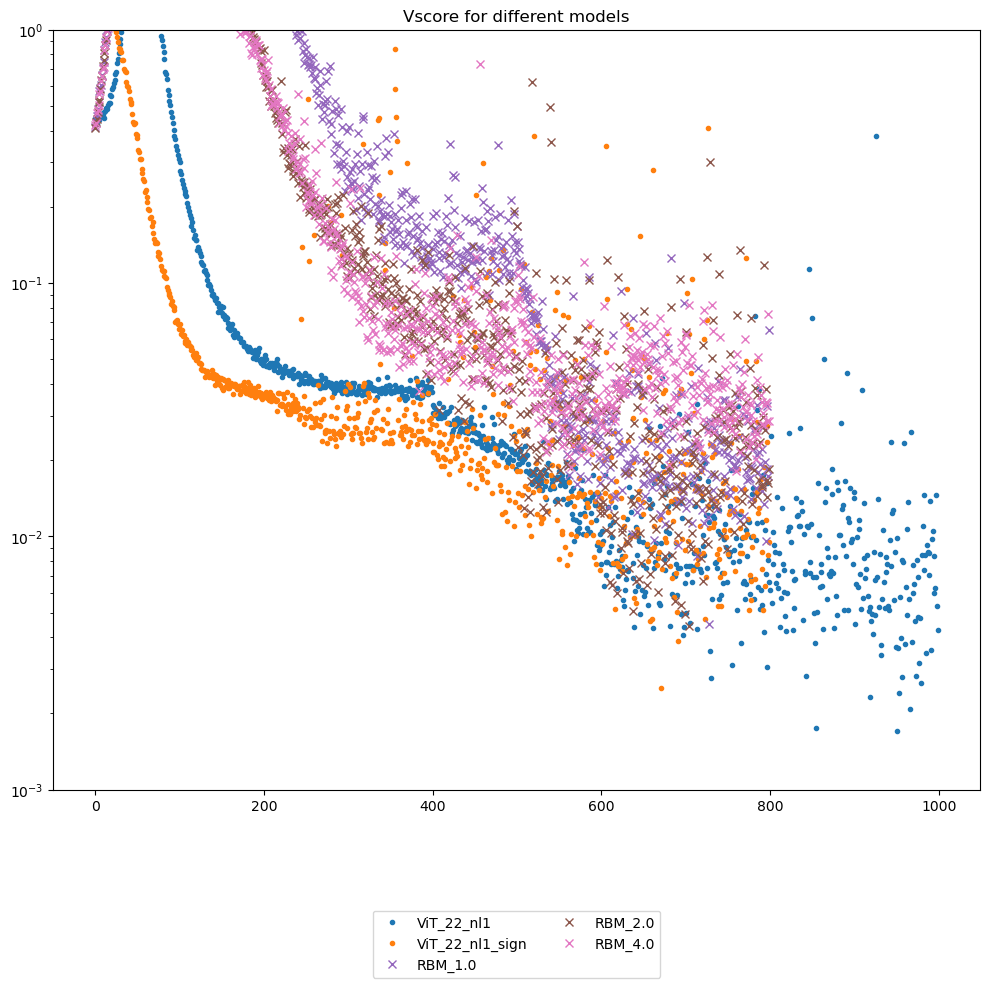

In [15]:
plt.figure(figsize=(10, 10))

plt.title('Vscore for different models')
step1 = len(data_opt['nl1_xy22']['Vscore'])
plt.semilogy(data_opt['nl1_xy22']['Vscore'], label='ViT_22_nl1', color='tab:blue', linestyle='', marker='.')
step2 = len(data_opt['nl1_xy22_transflip']['Vscore'])
plt.semilogy(jnp.arange(step1, step1 + step2), data_opt['nl1_xy22_transflip']['Vscore'], color='tab:blue', linestyle='', marker='.')
step3 = len(data_opt['nl1_xy22_transflip_refined']['Vscore'])
plt.semilogy(jnp.arange(step2 + step1, step1 + step2 + step3), data_opt['nl1_xy22_transflip_refined']['Vscore'], color='tab:blue', linestyle='', marker='.')

step1 = len(data_opt['nl1_xy22_sign']['Vscore'])
plt.semilogy(data_opt['nl1_xy22_sign']['Vscore'], label='ViT_22_nl1_sign', color='tab:orange', linestyle='', marker='.')
step2 = len(data_opt['nl1_xy22_sign_transflip']['Vscore'])
plt.semilogy(jnp.arange(step1, step1 + step2), data_opt['nl1_xy22_sign_transflip']['Vscore'], color='tab:orange', linestyle='', marker='.')

# step1 = len(data_opt['nl2_xy22']['Vscore'])
# plt.semilogy(data_opt['nl2_xy22']['Vscore'], label='ViT_22_nl2', color='tab:red', linestyle='', marker='.')
# step2 = len(data_opt['nl2_xy22_transflip']['Vscore'])
# plt.semilogy(jnp.arange(step1, step1 + step2), data_opt['nl2_xy22_transflip']['Vscore'], color='tab:red', linestyle='', marker='.')
# step3 = len(data_opt['nl2_xy22_transflip_refined']['Vscore'])
# plt.semilogy(jnp.arange(step2 + step1, step1 + step2 + step3), data_opt['nl2_xy22_transflip_refined']['Vscore'], color='tab:red', linestyle='', marker='.')

# step1 = len(data_opt['nl3_xy22']['Vscore'])
# plt.semilogy(data_opt['nl3_xy22']['Vscore'], label='ViT_22_nl3', color='tab:green', linestyle='', marker='.')
# step2 = len(data_opt['nl3_xy22_transflip']['Vscore'])
# plt.semilogy(jnp.arange(step1, step1 + step2), data_opt['nl3_xy22_transflip']['Vscore'], color='tab:green', linestyle='', marker='.')

step1 = len(data_opt['_alpha1.0']['Vscore'])
plt.semilogy(data_opt['_alpha1.0']['Vscore'], label='RBM_1.0', color='tab:purple', linestyle='', marker='x')
step2 = len(data_opt['transflip_alpha1.0']['Vscore'])
plt.semilogy(jnp.arange(step1, step1 + step2), data_opt['transflip_alpha1.0']['Vscore'], color='tab:purple', linestyle='', marker='x')

step1 = len(data_opt['_alpha2.0']['Vscore'])
plt.semilogy(data_opt['_alpha2.0']['Vscore'], label='RBM_2.0', color='tab:brown', linestyle='', marker='x')
step2 = len(data_opt['transflip_alpha2.0']['Vscore'])
plt.semilogy(jnp.arange(step1, step1 + step2), data_opt['transflip_alpha2.0']['Vscore'], color='tab:brown', linestyle='', marker='x')

step1 = len(data_opt['_alpha4.0']['Vscore'])
plt.semilogy(data_opt['_alpha4.0']['Vscore'], label='RBM_4.0', color='tab:pink', linestyle='', marker='x')
step2 = len(data_opt['transflip_alpha4.0']['Vscore'])
plt.semilogy(jnp.arange(step1, step1 + step2), data_opt['transflip_alpha4.0']['Vscore'], color='tab:pink', linestyle='', marker='x')

plt.ylim(1e-3, 1.0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=2)
plt.tight_layout()
plt.show()

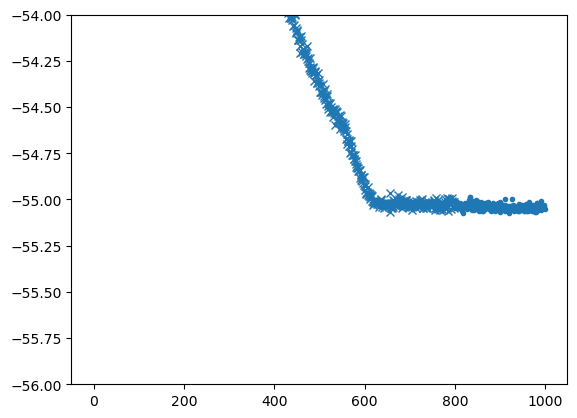

In [16]:
plt.figure()

step1 = len(data_opt['nl1_xy22']['Energy'])
plt.plot(data_opt['nl1_xy22']['Energy'], label='ViT_22_nl1', color='tab:blue', linestyle='', marker='x')
step2 = len(data_opt['nl1_xy22_transflip']['Energy'])
plt.plot(jnp.arange(step1, step1 + step2), data_opt['nl1_xy22_transflip']['Energy'], color='tab:blue', linestyle='', marker='x')
step3 = len(data_opt['nl1_xy22_transflip_refined']['Energy'])
plt.plot(jnp.arange(step2 + step1, step1 + step2 + step3), data_opt['nl1_xy22_transflip_refined']['Energy'], color='tab:blue', linestyle='', marker='.')
plt.ylim(-56.0, -54.0)
plt.show()

In [17]:
print(data_opt['transflip_alpha1.0']['Energy'][-1], data_opt['transflip_alpha1.0']['Variance'][-1], data_opt['transflip_alpha1.0']['Vscore'][-1])
# print(data_opt['transflip_alpha2.0']['Energy'][-1], data_opt['transflip_alpha2.0']['Variance'][-1], data_opt['transflip_alpha2.0']['Vscore'][-1])
print(data_opt['transflip_alpha4.0']['Energy'][-1], data_opt['transflip_alpha4.0']['Variance'][-1], data_opt['transflip_alpha4.0']['Vscore'][-1])

# print(data_opt['nl2_xy22_transflip_refined']['Energy'][-1])
# print(data_opt['nl2_xy22_transflip_refined']['Variance'][-1])
# print(data_opt['nl2_xy22_transflip_refined']['Vscore'][-1])


-54.97826532806934 5.496392275176078 0.06546095802535928
-54.90888740607471 2.384763716032139 0.028473886511150293


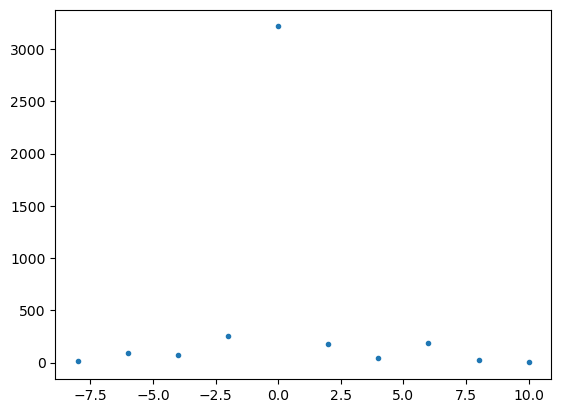

In [18]:
us, cs = jnp.unique(jnp.sum(vit_22_nl2.samples.reshape(-1, 36), axis=-1)/2, return_counts=True)
plt.plot(us, cs, '.')

In [27]:
vit_22_nl2.expect(Mtot)

-0.007+0.000j ± 0.017 [σ²=0.011, R̂=1.3605]

In [20]:
vit_22_nl3.reset()
print(vit_22_nl3.expect(Ha36))


-55.000+0.014j ± 0.022 [σ²=1.484, R̂=1.0067]


In [76]:
vit_22_sign.reset()

In [77]:
print(vit_22.expect(Ha36))

print(vit_22_sign.expect(Ha36_SS))


print(vit_22_nl3.expect(Ha36))
# vit_22_sign.expect(Ha16_SS)

-55.027+0.000j ± 0.011 [σ²=0.600, R̂=1.0024]
-55.032+0.000j ± 0.013 [σ²=0.790, R̂=1.0037]
-54.903+0.008j ± 0.084 [σ²=6.221, R̂=1.0323]


### Compute magneitzation of the different variational states

In [13]:
print(vit_22.expect(Mtot), vit_22_sign.expect(Mtot), vit_22_nl3.expect(Mtot))

0.00052+0.00000j ± 0.00060 [σ²=0.00118, R̂=1.0074] -0.00033+0.00000j ± 0.00040 [σ²=0.00104, R̂=1.0028] -0.0075+0.0000j ± 0.0072 [σ²=0.0031, R̂=1.2404]


In [14]:
print(vs_rbm1.expect(Mtot), vs_rbm2.expect(Mtot), vs_rbm4.expect(Mtot))

0.00062+0.00000j ± 0.00073 [σ²=0.00114, R̂=1.0079] 0.0010+0.0000j ± 0.0017 [σ²=0.0071, R̂=1.0062] -0.00000+0.00000j ± 0.00050 [σ²=0.00118, R̂=1.0021]


In [15]:
M_rbm4 = vs_rbm4.expect(Mtot)

In [16]:
M_rbm4

-0.00000+0.00000j ± 0.00050 [σ²=0.00118, R̂=1.0021]

In [121]:
vit_22_nl2.expect(Ha36)

-53.1+0.0j ± 1.1 [σ²=38.3, R̂=1.3940]

#### Compute Spin Spin Correlations:

In [26]:
SpinSpin_Corrs = {}
SpinSpin_Corrs_Errs = {}
def compute_spin_spin_corr(vs, label, make_rotate=False, sublattice=None):
    values = []
    errs = []
    for j in range(1, hi2d.size):
        # op_stats = vs.expect(SpinSpin(0, j, hi2d, make_rotation=make_rotate, sublattice=sublattice) )
        op_stats = vs.expect(SpinSpin(0, j, hi2d, make_rotation=make_rotate, sublattice=sublattice).to_jax_operator()) 
        values.append(op_stats.mean)
        errs.append(op_stats.error_of_mean)
        
    SpinSpin_Corrs[label] = jnp.array(values)
    SpinSpin_Corrs_Errs[label] = jnp.array(errs)

In [32]:
vs_rbm1.reset()

In [27]:
sublatt = [0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17, 24, 25, 26, 27 ,28, 29]

In [33]:
compute_spin_spin_corr(vit_22, 'vit_22', make_rotate=False, sublattice=sublatt)
compute_spin_spin_corr(vit_22_sign, 'vit_22_sign', make_rotate=True, sublattice=sublatt)
compute_spin_spin_corr(vit_22_nl2, 'vit_22_nl2', make_rotate=False, sublattice=sublatt)
compute_spin_spin_corr(vit_22_nl3, 'vit_22_nl3', make_rotate=False, sublattice=sublatt)
compute_spin_spin_corr(vs_rbm1, 'rbm1', make_rotate=False, sublattice=sublatt)
compute_spin_spin_corr(vs_rbm2, 'rbm2', make_rotate=False, sublattice=sublatt)
compute_spin_spin_corr(vs_rbm4, 'rbm4', make_rotate=False, sublattice=sublatt)

In [14]:
# jnp.array(SpinSpin_Corrs['vit_22_nl2']).shape

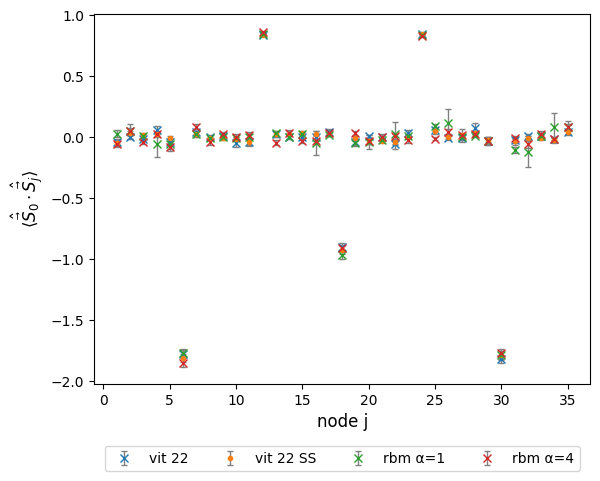

In [64]:
plt.figure()
# plt.title('Spin-Spin Correlation for 6x6 lattice')
plt.xlabel('node j', fontsize=12)
plt.ylabel(r'$\langle \hat{\vec{S}}_0 \cdot\hat{\vec{S}}_j \rangle$', fontsize=12)

plt.errorbar(jnp.arange(1,36), y=SpinSpin_Corrs['vit_22'].real, yerr=SpinSpin_Corrs_Errs['vit_22'], fmt= 'x',  ecolor='gray', elinewidth=1, capsize=2, label = 'vit 22')
plt.errorbar(jnp.arange(1,36), y=SpinSpin_Corrs['vit_22_sign'].real, yerr= SpinSpin_Corrs_Errs['vit_22_sign'], fmt='.', ecolor='gray', elinewidth=1, capsize=2, label = 'vit 22 SS')
# plt.plot(SpinSpin_Corrs['vit_22_nl3'], 'o', label = 'ViT_22_nl3')
# plt.errorbar(jnp.arange(1,36), y=SpinSpin_Corrs['vit_22_nl2'].real, yerr=SpinSpin_Corrs_Errs['vit_22_nl2'], fmt='.', color = 'firebrick', ecolor='gray', elinewidth=1, capsize=2, label = r'vit 22 $n_l=2$')
plt.errorbar(jnp.arange(1,36), y=SpinSpin_Corrs['rbm1'].real,  yerr=SpinSpin_Corrs_Errs['rbm1'], fmt='x',  color = 'tab:green', ecolor='gray', elinewidth=1, capsize=2, label = 'rbm α=1')
# plt.plot(SpinSpin_Corrs['rbm2'], 'x', color = 'green', label = 'rbm2')
plt.errorbar(jnp.arange(1,36), y=SpinSpin_Corrs['rbm4'].real, yerr=SpinSpin_Corrs_Errs['rbm4'], fmt='x', color = 'tab:red', ecolor='gray', elinewidth=1, capsize=2, label = 'rbm α=4')

plt.legend(ncols=4, loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.savefig(fname = 'Spin_Corrs_6x6.png', dpi=300, bbox_inches='tight')
plt.show()

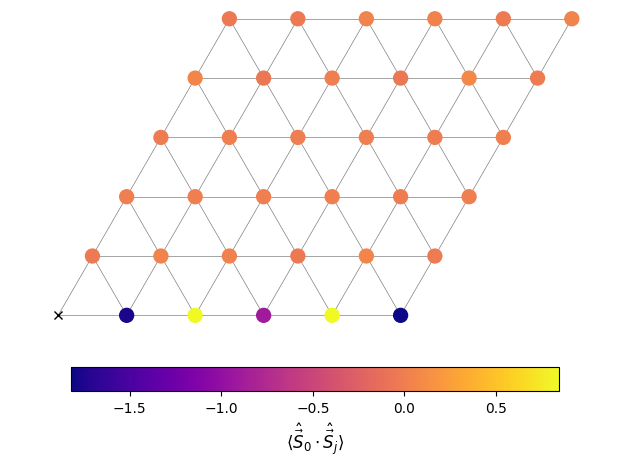

In [67]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
# plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ for vit_22 on 6x6 lattice')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
sc = plt.scatter(x=xcoords[1:], y=ycoords[1:], c=SpinSpin_Corrs['vit_22'].real, cmap='plasma', s=100, label=' α=1')

cbar = plt.colorbar(sc, orientation='horizontal', pad=0.1, shrink=0.8)  # Adjust shrink to control size
cbar.set_label(r'$\langle \hat{\vec{S}}_0 \cdot\hat{\vec{S}}_j \rangle$', fontsize=12)

plt.tight_layout()
plt.savefig(fname = 'SpinSpin_Corrs_6x6_Lattice_vit_22.png', dpi=300)
plt.show()


In [30]:
S0S8 = vit_22.expect(SpinSpin(0, 12, hi2d, make_rotation=True, sublattice=pHa['sublattice']) / 3)

S0S24 = vit_22.expect(SpinSpin(0, 24, hi2d, make_rotation=True, sublattice=pHa['sublattice']) / 3)

print(S0S8, S0S24)

0.2875+0.0000j ± 0.0044 [σ²=0.0633, R̂=1.0043] 0.2863-0.0000j ± 0.0043 [σ²=0.0617, R̂=1.0042]


## Spin structure factor

In [42]:
pi = np.pi
nodes = [
    (-4*pi/3, 0),  # Leftmost node
    (-2*pi/3, -2*pi/np.sqrt(3)),  # Bottom left
    (2*pi/3, -2*pi/np.sqrt(3)),  # Bottom right
    (4*pi/3, 0),  # Rightmost node
    (2*pi/3, 2*pi/np.sqrt(3)),  # Top right
    (-2*pi/3, 2*pi/np.sqrt(3)),  # Top left
    (-4*pi/3, 0)  # Close the hexagon by repeating the first node
]

x_coords, y_coords = zip(*nodes)

In [44]:
ds = Create_Differences(TriGraph)
sss, sss_err = Create_SpinSpin_Vec(vit_22,hi2d, TriGraph, get_error=True, sharding=True)
ks = FourierPoints_In_BrioullinZone(6, 100)

Sk_vit22, Sk_vit22_err = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, sss, hi2d.size, sss_err)

In [23]:
ind = np.where(np.all(np.isclose(ks , (3.14159, 1.813799)), axis=1))
ind2 = np.where(np.all(np.isclose(ks , (3.14159265,  0.60459979)), axis=1))
print(ind, ind2)

(array([123]),) (array([114]),)


In [19]:
np.max(Sk_vit22)

Array(9.27367473-0.00066166j, dtype=complex128)

In [24]:
print(Sk_vit22[ind2], '+-', Sk_vit22_err[ind2])
print(Sk_vit22[ind], '+-', Sk_vit22_err[ind])

[9.23352106+0.00243912j] +- [0.02574535]
[9.27367473-0.00066166j] +- [0.02574535]


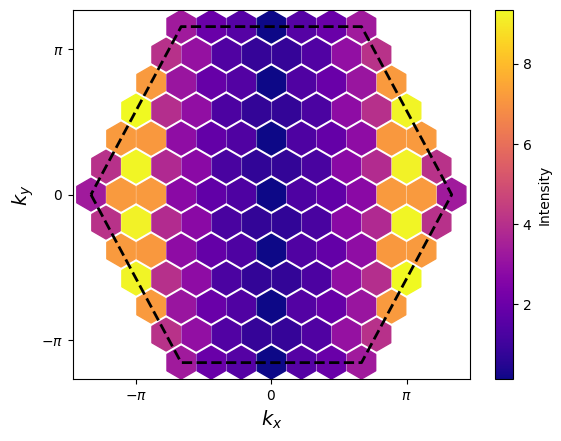

In [55]:
thickness = 20000 / L**2 
# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit22.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# plt.title('Structure Factor for ViT_22')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels, )
plt.yticks(ticks, tick_labels, )
plt.xlabel(r'$k_x$', fontsize=14)
plt.ylabel(r'$k_y$', fontsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params()
cbar.set_label('Intensity',)  # Add label to colorbar
plt.savefig(fname='Structure_Factor_6x6_vit_22.png', dpi=300)
plt.show()

In [34]:
ds = Create_Differences(TriGraph)
sss_rbm1 = Create_SpinSpin_Vec(vs_rbm1,hi2d, TriGraph)
ks = FourierPoints_In_BrioullinZone(6, 100)
Sk_rbm1= vmap(Single_Struc_Fac, in_axes=(0, None, None, None))(((ks)), ds, sss_rbm1, hi2d.size)

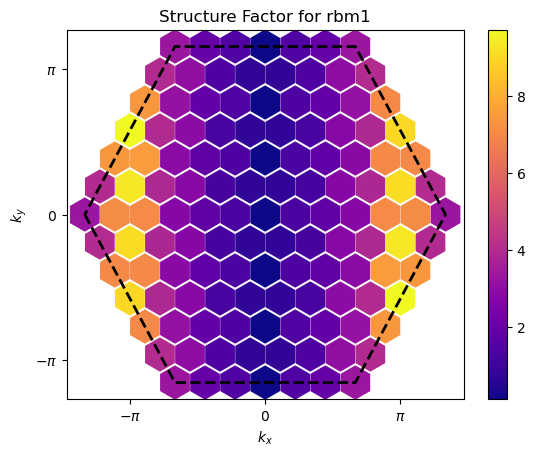

In [35]:
thickness = 20000 / L**2 
# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_rbm1.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
plt.title('Structure Factor for rbm1')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.show()

## attention map investigation

In [36]:
# vit_22.parameters['ViT_2d_0']['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0'].keys()
alpha_nl1_22 = vit_22.parameters['ViT_2d_0']['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0']['alpha']
alpha_nl1_22.shape

(6, 9)

In [66]:
np.rot90(np.arange(0,9).reshape(3,3))

array([[2, 5, 8],
       [1, 4, 7],
       [0, 3, 6]])

<bound method _reshape of Array([0.28663532, 0.2141521 , 0.00575065, 0.45982009, 0.10823058,
       0.00516496, 0.50306142, 0.21731011, 0.00660404], dtype=float64)>


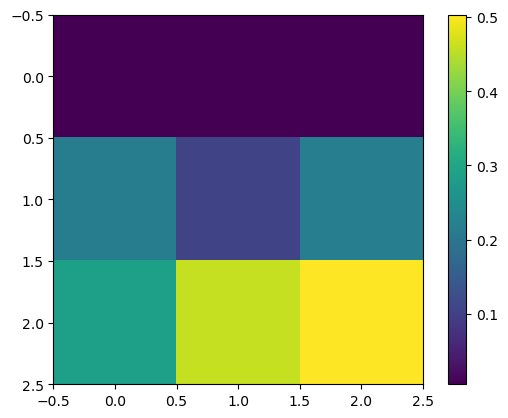

In [67]:
alpha_av = jnp.mean(jnp.abs(alpha_nl1_22), axis=0)
print(alpha_av.reshape)
plt.imshow(np.rot90(alpha_av.reshape(3,3)), cmap='viridis', interpolation='nearest')
plt.colorbar()